In [ ]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
#!git clone https://github.com/Kaggle/kaggle-environments.git
#!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v5 https://github.com/Georgemouts/football.git #https://github.com/google-research/football.git  
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:13 http:

In [ ]:
#from gfootball.env.football_env import FootballEnv
#from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import gfootball 
import math

In [ ]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')

new_observation,reward,done,info = env.step(5)
print(new_observation)

[ 1.85470306e-03  1.07221614e-10  3.76440282e-03  2.59753018e-11
  1.99999996e-02 -0.00000000e+00  1.10597342e-01 -0.00000000e+00
  0.00000000e+00 -1.91829144e-03]


In [ ]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.n_actions)
  

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
    #x=F.relu(self.fc3(x))
    return actions

In [ ]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 10000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=128, fc2_dims=128)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions 
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
     
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    


    batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     

    batch_index = np.arange(self.batch_size , dtype=np.int32)

    state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch] 
  
    q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] 
    q_next = self.Q_eval.forward(new_state_batch)

    q_next[terminal_batch] = 0.0
    q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

    loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min

---Avg reward last: 53.33816872344154 Avg score last 1.0 Avg steps 117.0 episode= 0 ---
---Avg reward last: 79.75409757290048 Avg score last 0.9 Avg steps 107.9 episode= 10 ---
---Avg reward last: 114.60510335236197 Avg score last 0.9 Avg steps 106.4 episode= 20 ---
---Avg reward last: 115.14847042842614 Avg score last 0.9 Avg steps 92.8 episode= 30 ---
---Avg reward last: 114.64501853864274 Avg score last 0.9 Avg steps 89.0 episode= 40 ---
---Avg reward last: 115.60306959885675 Avg score last 0.9 Avg steps 87.1 episode= 50 ---
Last 50 episodes avg score 0.9


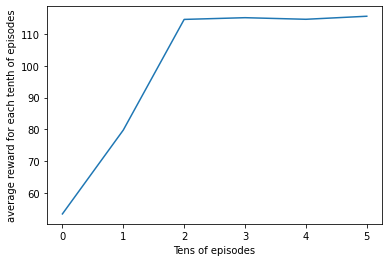

---Avg reward last: 118.13814954916691 Avg score last 1.0 Avg steps 86.4 episode= 60 ---
---Avg reward last: 115.88420780458348 Avg score last 0.9 Avg steps 88.1 episode= 70 ---
---Avg reward last: 117.90457841825294 Avg score last 1.0 Avg steps 86.7 episode= 80 ---
---Avg reward last: 117.9484893176062 Avg score last 1.0 Avg steps 86.4 episode= 90 ---
---Avg reward last: 115.7099696866095 Avg score last 0.9 Avg steps 87.4 episode= 100 ---


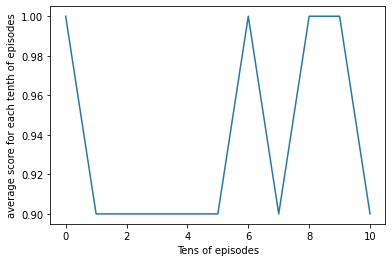

Last 50 episodes avg score 0.96


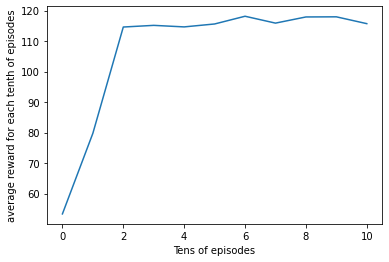

---Avg reward last: 118.28771155681527 Avg score last 1.0 Avg steps 86.9 episode= 110 ---
---Avg reward last: 119.12622785302179 Avg score last 1.0 Avg steps 86.1 episode= 120 ---
---Avg reward last: 118.4271570564922 Avg score last 1.0 Avg steps 86.8 episode= 130 ---
---Avg reward last: 118.60333319395711 Avg score last 1.0 Avg steps 86.3 episode= 140 ---
END OF TRAINING
Last 50 episodes avg score 1.0


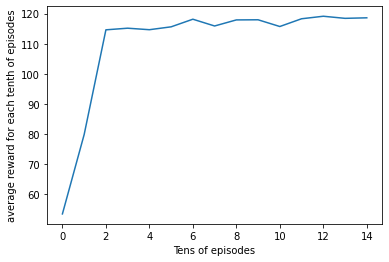

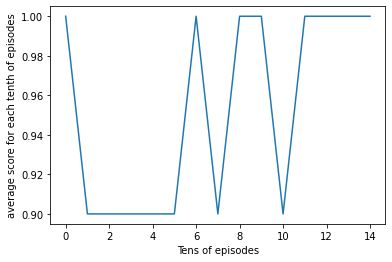

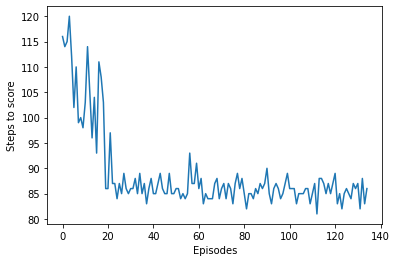

In [ ]:
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 10 states 


#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12]

#Create Objects

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 64 ,lr=0.00115 ,input_dims= [10], n_actions = len(Action_list) )# batch = best 256


scores,ep_history =[],[]
avg_score_list=[]
avg_rew_list =[]

num_of_eps = 801
rew_list =[]
score_list = []
step_list =[]
goal_steps=[]
for i in range(num_of_eps) : 
  terminal =0
  episode =0
  score =0 
  eps_rew=0
  steps=0
  done=False 
  observation =env.reset()
  act =0 #first action will be to move right 
  shout=0 #mporei na kanei shout 1 fora se kathe ep
  eps_rew=0
  while not done:

    #CUSTOMIZE ACTIONS HERE 
   
    if(act ==0 ): # do a step to the opponent side
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      act=1
    

    #CUSTOM ACTIONS
    action = agent.choose_action(observation) # from 1-4 which is index to action list

    while((observation[0]<0.65)  and (Action_list[action]==12)): #Do not shout outside box
      action = agent.choose_action(observation)
     

    if(shout==0):   #if he shouts he cant do anything till the episode ends
      new_observation,reward,done,info = env.step(Action_list[action])
      
      if(Action_list[action]==12):
        shout=1
    else:
      new_observation,reward,done,info = env.step(0)
      action=0 
 #END OF CUSTOM ACTIONS

    #CUSTOM REWARDS

    if(done ==1 and reward != 1): #if ball is out ,loses -10
      reward = reward -10


    if(reward==1 and  done ==1): #if agent scores , wins +10
      reward += 10
      goal_steps.append(steps)

    if (Action_list[action]==5 and observation[0]<0.65 and (observation[0]<- 0.08 or observation[0]>0.08)):#If agent is in the same line with goal and goes right
      reward = reward +2

    reward = reward - ( math.sqrt( ((0.935 - observation[4])**2) + (0 -observation[5])**2 ) *0.3) #the longer the distance from the goal , the negative reward is bigger
  

    #END OF CUSTOM REWARDS 
 
    score+= reward

    #for prints
    eps_rew+=reward

    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    
#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)
  
  #Terminate if last 50, 100 and 200 episodes has the same score average
  if((abs(np.mean(score_list[-50:]) - np.mean(score_list[-100:])) <=0.03) and (abs(np.mean(score_list[-100:]) - np.mean(score_list[-200:]))<=0.03) and  i>100):
    print("END OF TRAINING")
    break

  episode = episode +1 
  rew_list.append(eps_rew)

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      avg_score_list.append(np.mean(score_list[-10:]))
      avg_rew_list.append(np.mean(rew_list[-10:]))

  if (((i % 100)== 0) and i!=0) :
     plt.plot(avg_score_list)
     plt.xlabel('Tens of episodes')
     plt.ylabel('average score for each tenth of episodes')
     plt.plot()
     plt.show()
  if(((i%50)==0) and i!=0):
     print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
     plt.plot(avg_rew_list)
     plt.xlabel('Tens of episodes')
     plt.ylabel('average reward for each tenth of episodes')
     plt.plot()
     plt.show()
  

print("Last 50 episodes avg score",(np.mean(score_list[-50:])))
plt.plot(avg_rew_list)
plt.xlabel('Tens of episodes')
plt.ylabel('average reward for each tenth of episodes')
plt.plot()
plt.show()

plt.plot(avg_score_list)
plt.xlabel('Tens of episodes')
plt.ylabel('average score for each tenth of episodes')
plt.plot()
plt.show()


plt.plot(goal_steps)
plt.xlabel('Episodes')
plt.ylabel('Steps to score')
plt.plot()
plt.show()




# Average Reward for each tenth of episodes

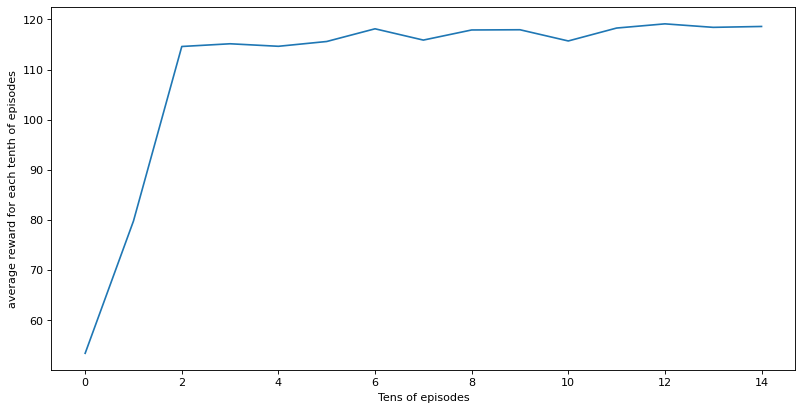

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(12, 6), dpi=80)
plt.xlabel('Tens of episodes')
plt.ylabel('average reward for each tenth of episodes')
plt.plot(avg_rew_list)

# Reward per episode

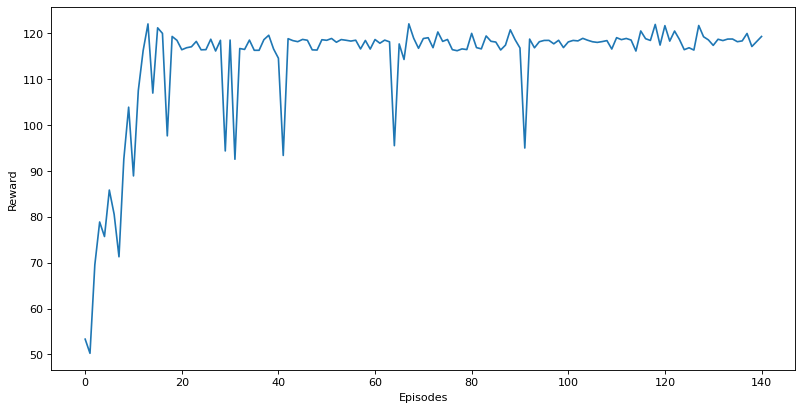

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(rew_list)

# Average Score for each tens of episodes



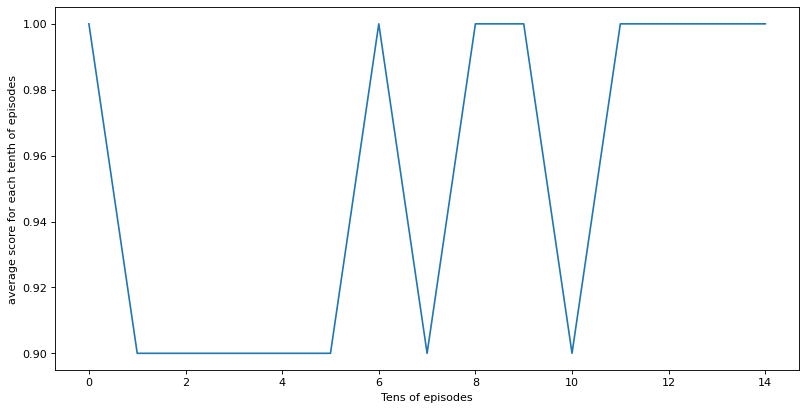

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.xlabel('Tens of episodes')
plt.ylabel('average score for each tenth of episodes')
plt.plot(avg_score_list)

# Score per Episode

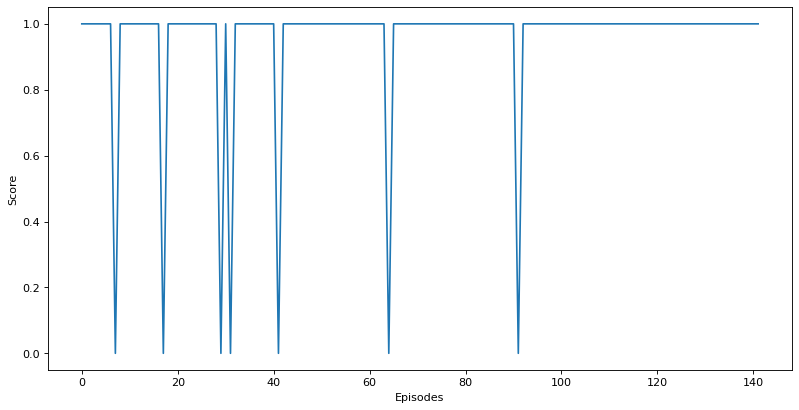

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.plot(score_list)

# Steps to Score for each episode

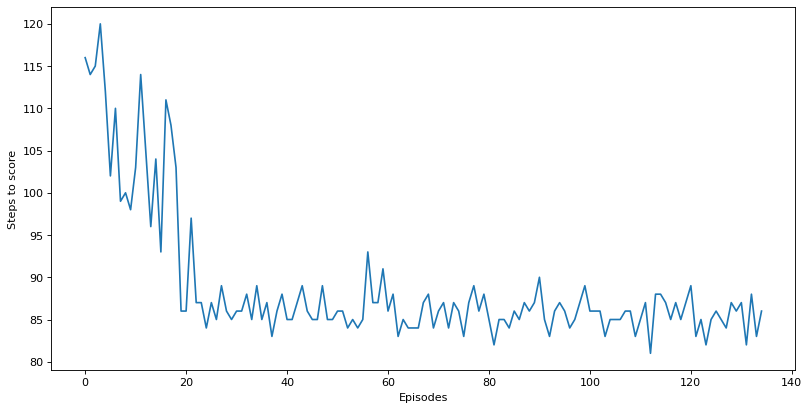

In [ ]:
figure(figsize=(12, 6), dpi=80)
plt.xlabel('Episodes')
plt.ylabel('Steps to score')
plt.plot(goal_steps)